# Extração da característica de relação sinal-ruído de dados de EEG

A ideia é utilizar dados fictícios de ruído e sinal "bom"., para criarmos a relação dos dois sinais e obter como resultado um sinal de interesse "limpo".

A partir deste sinal, podemos no contexto de caracterização de foco, ainda extrair os rítmos cerebrais ou então classificar sinais com a presença ou não de foco, de forma que as amostras de sinais extraídas de um buffer sejam rotuladas com com a presença ou não de foco.

Esta atividade pode ser realizada em conjunto com um classificador comumente utilizado, como é o caso do SVM. Neste caso, uma porcetagem das amostras são utilizadas para treino e o restante para teste (p.e. 30 e 70% respectivamente).

In [1]:
import mne
import numpy as np
from scipy.signal import welch
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [2]:
# definição do info (MNE)

n_channels = 8
ch_types = ['eeg'] * n_channels
sfreq = 250
ch_names = ["F3", "Fz", "F4", "C3", "Cz", "C4", "P3", "P4"]
info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)
info.set_montage("standard_1020")

# Leitura do dado basal (60 segundos) e amostra (5 minutos)

basal = '../dataset/s5/tF/OpenBCI-RAW-2023-11-06_19-56-20.txt'
basal_ob = np.loadtxt(basal, delimiter=',', skiprows=5, usecols=range(1, 9)).astype(np.float32)
data_noise_basal = basal_ob[21150:36150,:]    # 60 segundos de basal

inicio_amostra = sfreq * 120                  
final_amostra = inicio_amostra + sfreq * 60 * 5
data_amostra = basal_ob[inicio_amostra:final_amostra,:]      # 5 minutos de amostra


data_amostra_mne = mne.io.RawArray(data_amostra.T, info)
data_amostra_mne.notch_filter(freqs=60)
data_amostra_mne.filter(l_freq=4, h_freq=100)
freqs, data_amostra_mne_dominio_frequencia = welch(data_amostra_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
data_amostra_mne_dominio_frequencia_normalizada = scaler.fit_transform(data_amostra_mne_dominio_frequencia)

data_noise_basal_mne = mne.io.RawArray(data_noise_basal.T, info)
data_noise_basal_mne.notch_filter(freqs=60)
data_noise_basal_mne.filter(l_freq=4, h_freq=100)
freqs, data_noise_basal_mne_dominio_frequencia = welch(data_noise_basal_mne.get_data(), fs=250, nperseg=1024, noverlap=512)
scaler = StandardScaler()
fft_result_basal = scaler.fit_transform(data_noise_basal_mne_dominio_frequencia)


Creating RawArray with float64 data, n_channels=8, n_times=75000
    Range : 0 ... 74999 =      0.000 ...   299.996 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband at

[0, 0, 0, 1]
Amostra alvo: 1
Amostra descarte: 0
[0, 0, 0, 2]
Amostra alvo: 2
Amostra descarte: 0
[0, 0, 0, 3]
Amostra alvo: 3
Amostra descarte: 0
[0, 0, 0, 4]
Amostra alvo: 4
Amostra descarte: 0
[0, 0, 0, 5]
Amostra alvo: 5
Amostra descarte: 0
[0, 0, 0, 6]
Amostra alvo: 6
Amostra descarte: 0
[0, 0, 0, 7]
Amostra alvo: 7
Amostra descarte: 0
[0, 0, 0, 8]
Amostra alvo: 8
Amostra descarte: 0
[0, 0, 0, 9]
Amostra alvo: 9
Amostra descarte: 0
[0, 0, 0, 10]
Amostra alvo: 10
Amostra descarte: 0
[0, 0, 0, 11]
Amostra alvo: 11
Amostra descarte: 0
[0, 0, 0, 12]
Amostra alvo: 12
Amostra descarte: 0
[0, 0, 0, 13]
Amostra alvo: 13
Amostra descarte: 0
[0, 0, 0, 14]
Amostra alvo: 14
Amostra descarte: 0
[0, 0, 0, 15]
Amostra alvo: 15
Amostra descarte: 0
[0, 0, 0, 16]
Amostra alvo: 16
Amostra descarte: 0
[0, 0, 0, 17]
Amostra alvo: 17
Amostra descarte: 0
[0, 0, 0, 18]
Amostra alvo: 18
Amostra descarte: 0
[0, 0, 0, 19]
Amostra alvo: 19
Amostra descarte: 0
[0, 0, 0, 20]
Amostra alvo: 20
Amostra descarte: 

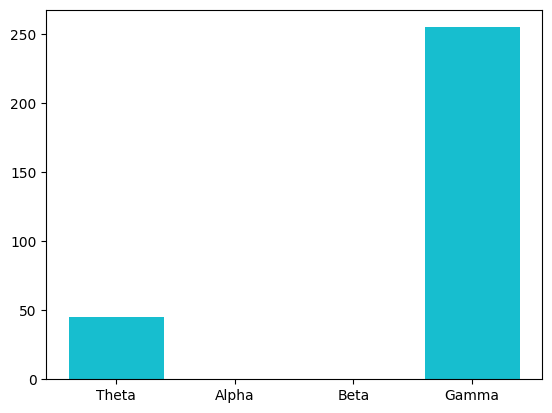

In [3]:
sr = 250            # taxa de amostragem
tamanho_amostra = 5 * 60
tamanho_amostra_pontos = tamanho_amostra * sr
tamanho_buffer = 5
tamanho_buffer_pontos = tamanho_buffer * sr
passo = 1 * 250
overlap = 4 * 250

# Definir os limites das bandas de frequência (em Hz)
theta_band = (4, 8)       # Theta: 4 - 8 Hz
alpha_band = (8, 13)      # Alpha: 8 - 13 Hz
beta_band = (13, 30)      # Beta: 13 - 30 Hz
gamma_band = (30, 100)    # Gamma: 30 - 100 Hz

# criando amostras de 5 segundos
amostras_alvo = []
amostras_descarte = []
amostras_theta = []

jump = 5            # 5 segundos de buffer
size = sr * jump    # quantidade de pontos avaliados


sample = {'f':[], 'nf':[]}
total_pc = {}
results = [0, 0, 0, 0]
for i in range(0, data_amostra_mne.n_times, passo):
    if i + size < data_amostra_mne.n_times:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[i]+jump)
    else:
        cut = data_amostra_mne.copy().crop(tmin=data_amostra_mne.times[i], tmax=data_amostra_mne.times[-1])  
    # Número de pontos por segmento
    nperseg = 128
    # Quantidade de sobreposição entre segmentos
    noverlap = nperseg // 2
    #cut.set_eeg_reference(ref_channels='average')
    cut = cut.get_data()

        # realizando a média dos 8 eletrodos
    # no caso do trabalho, analizar os canais separadamente.
    #   Para isso, vamos aplicar o filtro espacial, no qual
    #   podemos utilizar algoritmos específicos para a análise
    #   de EEG utilizando o CAR (Common Average Reference).

    freqs, psd = welch(cut, fs=sr, nperseg=nperseg, noverlap=noverlap)
    psd_media = np.average(psd, axis=0)

    # Encontrar os índices correspondentes às frequências de interesse
    theta_idxs = np.where((freqs >= theta_band[0]) & (freqs <= theta_band[1]))[0]
    alpha_idxs = np.where((freqs >= alpha_band[0]) & (freqs <= alpha_band[1]))[0]
    beta_idxs = np.where((freqs >= beta_band[0]) & (freqs <= beta_band[1]))[0]
    gamma_idxs = np.where((freqs >= gamma_band[0]) & (freqs <= gamma_band[1]))[0]

    # Calcular a potência em cada banda de frequência por meio da integração da PSD
    bands = [np.sum(psd_media[theta_idxs]), np.sum(psd_media[alpha_idxs]), np.sum(psd_media[beta_idxs]), np.sum(psd_media[gamma_idxs])]
    # calculando a pontuação de cada banda para mostrar a porcentagem futura
    results[np.argmax(bands)] += 1
    if np.argmax(bands) == 2 or np.argmax(bands) == 3:
        sample['f'].append(psd_media)
    else:
        sample['nf'].append(psd_media)
    print(results)
    plot = plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)

    print("Amostra alvo: " + str(len(sample['f'])))
    print("Amostra descarte: " + str(len(sample['nf'])))


In [4]:
# Estimando o ruído de fundo (utilizando o sinal basal)

# média da potência no intervalo de tempo sem estímulo
base_power = np.average(fft_result_basal)
# média das médias de potência de todos os canais para estimar o ruído de fundo
estimated_background_noise = base_power
print(estimated_background_noise)

-1.1773125251385675e-16


In [5]:
# agora vamos adaptar ambas características 

# aplicando para o nosso sinal de interesse

# forçando (estragando) valor de "estimated_background_noise" para não sobrar valores negativos
lista = []
lista = sample['f'] + sample['nf']
for data_focus in lista:
    target_amplitudes_adjusted = data_focus - estimated_background_noise

    # subtraindo o ruído de fundo das amplitudes
    narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)
    print(narrow_band_SNR)
    print(narrow_band_SNR.shape)

    total_power = np.sum(target_amplitudes_adjusted)
    wide_band_SNR = 10 * np.log10(target_amplitudes_adjusted / total_power)
    print(wide_band_SNR)
    print(wide_band_SNR.shape)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
(65,)
[-23.42310755 -17.97105222 -12.33160805 -11.79837269 -14.19851983
 -14.65316917 -16.28171405 -16.07762083 -16.27338822 -18.51572957
 -18.904334   -19.00432485 -18.21657786 -19.14012611 -19.34617089
 -19.41715716 -20.9380491  -20.22758858 -20.58599531 -20.85748805
 -21.09397005 -20.75984983 -21.40230902 -21.87652065 -21.85376756
 -21.76254168 -21.92790164 -21.30858917 -20.75050494 -18.18297246
  -7.36037048  -6.53626021 -14.13654643 -19.87846611 -23.32825796
 -24.27661897 -23.53121859 -23.98485223 -25.52750851 -27.06753628
 -25.14801324 -24.02140124 -27.06092198 -28.16221045 -26.07696942
 -26.20843495 -26.32173466 -26.69002881 -26.69323781 -28.62970526
 -29.57321536 -29.88228951 -30.30158471 -31.75841297 -31.13181179
 -3

/tmp/ipykernel_32778/2719772385.py:12: RuntimeWarning: invalid value encountered in log2
  narrow_band_SNR = 10 * np.log2(target_amplitudes_adjusted / estimated_background_noise)


[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan]
(65,)
[-28.31672475 -19.20321252 -13.66900909 -11.22021687 -10.03624782
 -13.4142699  -15.41277741 -16.01054553 -17.7013591  -19.2357394
 -18.06677737 -18.80826493 -18.45136264 -17.54106781 -18.09488113
 -18.97591848 -17.9522146  -18.18413669 -18.84027769 -19.49949092
 -18.95168688 -20.54045119 -21.62550321 -20.5495689  -20.77043435
 -20.3916382  -20.89282198 -20.29151837 -18.78167694 -16.22553533
  -9.17969714  -8.75925381 -13.17412982 -19.42581198 -20.51774296
 -20.67857248 -21.18165099 -23.09370959 -23.89906413 -24.29168252
 -25.25580148 -25.46862883 -25.87162095 -26.22364989 -26.81532523
 -25.9512393  -24.9720006  -26.0499672  -25.75211191 -26.28681153
 -27.16855648 -27.83550946 -28.72831187 -28.77081262 -30.23410139
 -30

Acurácia: 1.0
Relatório de classificação:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        80

    accuracy                           1.00        90
   macro avg       1.00      1.00      1.00        90
weighted avg       1.00      1.00      1.00        90



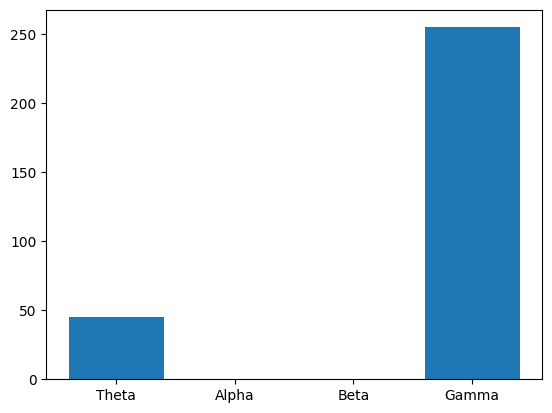

In [6]:
# Dividindo as amostras em treino e teste
features = sample['f'] + sample['nf']
labels = [1] * len(sample['f']) + [0] * len(sample['nf'])  # 1 para foco (Beta/Gamma) e 0 para não foco

# Dividir os dados em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)

# Transformar as amostras para um formato utilizável (normalização)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Criando o classificador SVM
svm_model = SVC(kernel='linear')

# Aplicando a seleção de características (RFE)
selector = RFE(svm_model, n_features_to_select=10, step=1)  # Reduzindo para 10 características mais relevantes
selector = selector.fit(X_train_scaled, y_train)

# Treinando o modelo SVM com as características selecionadas
svm_model.fit(X_train_scaled, y_train)

# Realizando a predição
y_pred = svm_model.predict(X_test_scaled)

# Avaliação do modelo
print("Acurácia:", accuracy_score(y_test, y_pred))
print("Relatório de classificação:\n", classification_report(y_test, y_pred))

# Plotando as bandas de frequência novamente para ver os resultados
plt.bar(['Theta', 'Alpha', 'Beta', 'Gamma'], results)
plt.show()